# AutoML step by step tutorial with evolutionary algorithm
Author: Daniel Wiczew

Contact: daniel.wiczew@pwr.edu.pl

This tutorial was based on the (i.e. aging evolution) algorithm used in:

[E. Real, A. Aggarwal, Y. Huang, and Q. V. Le 2018. Regularized Evolution for Image Classifier Architecture Search](https://arxiv.org/abs/1802.01548).

If you want to know technical details about the algorithm, I really encourage to read it.

# Optimizing CNN architecture using evolutionary algorithm and CIFAR10 dataset.

[link text](https://)The tutorial aims to show the usefulness of simple evolutionary algorithms in AutoML type problems. To achieve it a simple, sequential model is employed with the aging evolution algorithm, that was recently used in Google Brain's paper (mentioned above). The algorithm performs a stochastic search using Tournament selection and mutations, where the aging process is performed by removing the oldest representative in the population. More is explained in the article associated with the notebook. 

In [2]:
import tensorflow as tf
import numpy as np
from matplotlib.pyplot import imshow
import random
import collections
import time
from copy import deepcopy 
# Set mixed precision for higher performance
dtype = 'mixed_float16'
policy = tf.keras.mixed_precision.experimental.Policy(dtype)
tf.compat.v2.keras.mixed_precision.experimental.set_policy(policy)

In [3]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [1]:
# Depending on the graphic card you pick up, the speed is higher of lower
# Actually for the mixed mode, tesla T4 is one of the best
!nvidia-smi

Wed Jun 17 06:04:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The notebook starts with constants, their importance will be explained later in the notebook, so don't worry. 
* `EPOCHS` - Number of epochs, the more, the slower which is not better here.
* `BATCH_SIZE` - Its a batch size, keep so that, it is multiple of validation's set size.
* `LEARNING_RATE = 0.01` - Learning rate used while training models. It is that high, since the Adam optimizer is used (an adaptive optimizer). 
* `MODEL_SIZE_MAX` - Maximal sequential size of the model (e.g. 6 layers).
* `MAX_NEUR` - Maximal number of filters/neurons, depending on the model you want to use. It is better to set it low and scale up it later (it will speed up search significantly). The architecture is preserved if you scale up the number of filters by 2, each layer.
* `ACTIVATION` - Activation function used in the convolutional layers.
* `BAD_MODEL_LOSS` - Some randomly generated models fail to compile, thus an arbitrary loss is set for this (Usually the smallest possible, that's why it's zero). 



In [4]:
# CONSTANTS
EPOCHS = 25
BATCH_SIZE = 2048
LEARNING_RATE = 0.01
# This is maximal number of layers
MODEL_SIZE_MAX = 10
# Maximal number of neurons in the dense layers
MAX_NEUR = 16
ACTIVATION = 'relu'
# Bad model loss
BAD_MODEL_LOSS = 0.0

# Gene definition
Here genes are defined. The genes form elements those combinations form solutions in the search space. The genes include:
* Identity function (key: -1): it's purpose is to put an empty connection between layers. It's like putting an empty layer, that's outputs what is on its input.
* Convolutional layer (key: 0) with strides 2 by 2 and convolution filter of size 3 by 3, where its size is defined by the `MAX_NEUR`.
* Batch Normalization (key: 1) normalizes out of the input during forward propagation with respect to the batch dimension, read more here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
* Batch Normalization with renormalization (key: 2) is similar as above but with renomralization, read more in the link above.
* MaxPool2D (key: 3) extracts the most profound features from the previous layers in the height and width image's dimensions. 

Generally, you can add a new one, but you have to change the `AnnModel` class and `random_architecture`, `mutation` methods to include those elements. 

In [5]:
# Gene dictionaries
# Values are initialized later for convolutional layer
available_genes = {-1: (tf.keras.layers.Lambda, lambda x: tf.identity(x)), # Empty element
                   0: (tf.keras.layers.Conv2D, 1), # Dense layer with
                   1: (tf.keras.layers.BatchNormalization, None), # Batch Normalization layer
                   2: (tf.keras.layers.BatchNormalization, ('renorm', True)), # Batch Normalization with renorm
                   3: (tf.keras.layers.MaxPool2D, (2, 2))} # Max Poooling with 2x2 strides

# DATASET
Here dataset is loaded and CIFAR10 is used. Since the major concern here is the speed of neural network performance evaluation, all means to speed up training are used. The dataset is truncated a bit thus (the `SIZE_TRAIN_PERCENT` and `SIZE_VALID_PERCENT` constants). Furthermore, it is turned gray (`TURN_GRAY` constant) to further speed up calculations. 
Also there is an option `HORIZ_FLIP` that extends the dataset by augumenting the data with horizontaly flipped images.

In [6]:
# Settings
TURN_GRAY = True
# Create horizontal flip copy
HORIZ_FLIP = True
SIZE_TRAIN_PERCENT = 1.0
SIZE_VALID_PERCENT = 1.0

# Download and load CIFAR10 dataset to the memory.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
num_classes = int(max(y_train)) + 1
# Add channel axis, due to removal of the last axis after turning images gray
if TURN_GRAY:
  # Turning images gray using dot product with vector [0.07, 0.72, 0.21] (RGB respectively)
  x_train, x_test = x_train.dot([0.07, 0.72, 0.21]), x_test.dot([0.07, 0.72, 0.21])

if x_train.ndim < 4:
  x_train, x_test = x_train[:, :, :, np.newaxis], x_test[:, :, :, np.newaxis]

# Calculate statistics for standarization
mean = np.mean(x_train)
var = np.var(x_train)
# Standarize:
x_train = (x_train - mean)/(var)
x_test = (x_test - mean)/(var)
# Normalize between 0 and 1 using minmax
min_feat = np.min(x_train)
max_feat = np.max(x_train)
x_train = (x_train - min_feat)/(max_feat - min_feat)
x_test = (x_test - min_feat)/(max_feat - min_feat)

# Horizontal flip
if HORIZ_FLIP:
  x_train = np.concatenate([x_train, np.flip(x_train, 2)])
  y_train = np.concatenate([y_train, y_train])

SIZE_TRAIN = int(len(x_train) * SIZE_TRAIN_PERCENT)
SIZE_VALID = int(len(x_test) * SIZE_VALID_PERCENT)

# Truncate dataset and change the vector's type to float32 (It is float64 initially)
x_train, y_train, x_test, y_test = (x_train.astype(np.float32)[:SIZE_TRAIN], 
                                    tf.one_hot(np.squeeze(y_train).astype(np.float32)[:SIZE_TRAIN], depth=num_classes), 
                                    x_test.astype(np.float32)[:SIZE_VALID], 
                                    tf.one_hot(np.squeeze(y_test).astype(np.float32)[:SIZE_VALID], depth=num_classes))

170500096/170498071 [==============================] - 6s 0us/step


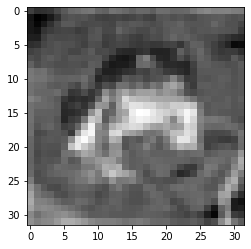

In [ ]:
# An image in the dataset
imshow(np.squeeze(x_train[0]), cmap='gray')

In [ ]:
x_train.shape

(100000, 32, 32, 1)

In [7]:
class AnnModel(tf.keras.Model):
  """A class representing a model architecture that is going to be trained in this tutorial. 
     The model is constructed based on the keys is defined in the `available_genes` dictionary. 
     Further, it's pre-defined output layer with softmax activation function, that predicts N classes, where N
     is evaluated based on the used dataset's out classes.

     How to build such a model you can find here:
     https://towardsdatascience.com/creating-a-trashy-model-from-scratch-with-tensorflow-2-an-example-with-an-anomaly-detection-27f0d1d7bd00

     Arguments:
        gene_dictionary: Contains all possible layers that could be added.
        model_list: List with layers that, are going to be compiled into the model,
              it will be explained further in detail. 
                         
  """
  def __init__(self, gene_dictionary=None, model_list=None): 
    super(AnnModel, self).__init__()
    self.gene_dictionary = gene_dictionary
    self.model_list = model_list
    # Last layer to calculate class probabilities
    self.last_dense = tf.keras.layers.Dense(num_classes, activation='softmax')
    # Current model that is going to be used in the `__call__` method
    self.current_model = []
    # Flatten layer, to flatten 2D image's vector into an 1D vector.
    self.flatten = tf.keras.layers.Flatten()
    for el_ind, param in self.model_list:
      element, _ = self.gene_dictionary[el_ind]
      if param is None:
        layer = element()
      elif el_ind == 0:
        layer = element(param, kernel_size=(3, 3), strides=(2, 2), activation=ACTIVATION)
      elif callable(param):
        layer = element(param)
      elif isinstance(param, float):
        layer = element(param)
      elif isinstance(param[0], str):
        layer = element(**dict([param]))
      elif isinstance(param, tuple):
        layer = element(param)
      self.current_model.append(layer)
    self.current_model.append(self.flatten)
    self.current_model.append(self.last_dense)

  def call(self, inp_x):
     """Call 
     """ 
     x = inp_x
     for layer in self.current_model:
       x = layer(x)
     return x
  
def init_train_and_eval(model_list):
  """Train and evaluated a model passed as the model_list. The evaluation
     is based on the highest validation accuracy, during the training. It is
     to ommit overfiting due to too high number of epochs.

     Arguments:
        model_list: List with layers that, are going to be compiled into the model,
              it will be explained further in detail.
  """
  try:
    model = AnnModel(gene_dictionary=available_genes,
                     model_list=model_list)
    learning_rate = LEARNING_RATE
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, metrics=["accuracy"], loss="categorical_crossentropy")
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
                        shuffle=True)
  except ValueError:
    val_acc_last_n = BAD_MODEL_LOSS
    return val_acc_last_n
  else:
    val_acc_last_n = history.history['val_accuracy']
    return float(val_acc_last_n[-1])



# Model List
Here you can see how `model_list` is constructed. The numbers in the tuple in its first position represent the type of the layer, where the second position represents its parameter (e.g. number of filters). 

The code line is used to estimate the time needed for a given number of cycles, e.g. you will use 600 cycles and one such calculation take 20 s, then you will need about (600 * 20 s)/3600s/h ~ 3.3h. Remember that in Google Colab you can run code for the maximum of 12h. You can decrease the number of cycles to e.g. 100 just to see the effect of the algorithm, for example, if your time is very limited.

In [12]:
start_time = time.time()
model_list = [(0, 16), (1, None), (0, 16), (1, None), (0, 16), (1, None), (0, 16), (1, None), (1, None), (1, None)]
eval_val = init_train_and_eval(model_list)
print(model_list, eval_val)
print("Calculation time: {} s".format(time.time()-start_time))

[(0, 16), (1, None), (0, 16), (1, None), (0, 16), (1, None), (0, 16), (1, None), (1, None), (1, None)] 0.5881999731063843
Calculation time: 19.604204654693604 s


# Search Space Traversal
Below we define three functions:
* `random_element` - A function that returns a tuple with random element from the `available_genes` dictionary. You can try those functions separately below and see that it generates just tuples (like in the `model_list`). The probability distribution is weighted, to lower the probability for the identity connection, which is usually not that needed.
*`random_architecture` - Returns `model_list` with size of `MODEL_SIZE_MAX` with random elements defined in the `random_element` function.
* `mutate arch` - Mutates one architecture by randomly substituting some elements of the architecture using the `random_element` function. 

In [ ]:
def random_element():
  """Returns an random elements as a tuple with
     (element's key, element's parameter).
  """
  min_ind = min(list(available_genes.keys()))
  max_ind = max(list(available_genes.keys()))
  list_ind = list(range(min_ind, max_ind+1))
  random_el = random.choices(population=list_ind,
                             k=1)[0]
  if random_el == -1:
    return (random_el, lambda x: tf.identity(x))
  elif random_el == 0:
    return (random_el, MAX_NEUR)
  elif random_el == 1:
    return (random_el, None)
  elif random_el == 2:
    return (random_el, ('renorm', True))
  elif random_el == 3:
    return (random_el, (2, 2))

def random_architecture(max_model_size=MODEL_SIZE_MAX):
  """Returns a random architecture as a list of tuples.
     
     Arguments: 
        max_model_size - numbers of layers that are going
                         to be generated.
     Returns: Random architecture as a list of tuples.
  """

  rand_arch_with_params = []
  for el in range(max_model_size):
    rand_arch_with_params.append(random_element())
  return rand_arch_with_params


def mutate_arch(parent_model_list):
  """Mutates the input architecture by substitution. The output architecture
     is forced to be different than the output, thus ensuring diversity.

     Arguments: 
          parent_model_list: An architecture as list of tuples

     Returns: An architecture different than the input.
  """
  
  parent_hash = hash(tuple(parent_model_list))
  model_len = len(parent_model_list)
  while True:
    rand_int = random.randint(0, 1)
    child_model = deepcopy(parent_model_list)
    if rand_int == 0:
    # Otherwise it will mutate the same object
      rand_i = random.randint(0, model_len-1)
      child_model[rand_i] = random_element()
      # Check if the mutation introduces something new 
      # sometimes it doesn't if not checked
    elif rand_int == 1:
      while True:
        rand_i = random.randint(0, model_len-1)
        rand_j = random.randint(0, model_len-1)
        if rand_i == rand_j:
          continue
        else:
          temp = child_model[rand_j]
          child_model[rand_j] = child_model[rand_i]
          child_model[rand_i] = temp
          break
    if hash(tuple(child_model)) != parent_hash:
      break
    else:
      del child_model
      continue
  return child_model

# Here you can test how these functions work

In [ ]:
random_element()

(3, (2, 2))

In [ ]:
random_arch = random_architecture()
print("The random architecture is: {}".format(random_arch))
print("Let's mutate it")
mutated_arch = mutate_arch(random_arch)
print("Now the architecture is {}".format(mutated_arch))

The random architecture is: [(0, 16), (-1, <function random_element.<locals>.<lambda> at 0x7f5860a997b8>), (3, (2, 2)), (0, 16), (3, (2, 2)), (0, 16), (3, (2, 2)), (0, 16), (2, ('renorm', True)), (0, 16)]
Let's mutate it
Now the architecture is [(0, 16), (-1, <function random_element.<locals>.<lambda> at 0x7f5860a997b8>), (3, (2, 2)), (0, 16), (3, (2, 2)), (0, 16), (0, 16), (0, 16), (2, ('renorm', True)), (0, 16)]


# Regularized Evolution Algorithm (Aging evolution) 

The regularized evolution (i.e. aging evolution) algorithm is written bellow. It's the heart of the Jupyter Notebook, it is responsible for all the work. The explanation is in the docstring and comments above code lines.

In [ ]:
def regularized_evolution(cycles, population_size, sample_size, init_population=None, init_history=None):
  """Algorithm for regularized evolution (i.e. aging evolution).
     The algorithms accept a number of cycles, population size, and sample selection size as required arguments. 
     The other two are not mandatory are serve the purpose of restarting the calculations.
     Thus immediately you can figure out what are outputs, which are history
     population in the last cycle and the best model found during the 
     evolutionary search.
     
  
     Arguments:
          cycles: Number of evolutionary cycles, in one cycle, one mutation and 
                  one evaluation (training a model and calculation of its performance)
                  is performed. The higher the number of cycles, the better model you
                  should find, but the computational cost increases linearly.
          population_size: The number of individuals held in the population. The bigger
                           the population, the more stable is the algorithm, and usually
                           converges quicker to better solutions. Nevertheless, the bigger
                           it is, the initiation is slower and takes longer to remove 
                           an bad individual due to aging.
          sample_size: The bigger it is, the stronger is evolutionary pressure. If it set
                       to one, then individuals are selected randomly, and if it equals 
                       the population size, then the best individual is always chosen. 
                       So it should be kept always in-between.

  Returns:
    history: a list of `Model` instances, with its scores (validation accuracies),
    population: the last population in the calculations, helpful for restarts
    best_of_all: the best model during calculations  
  """
  
  # Best individual, set to something inferior at the beginning
  best_of_all = ([0], 1e-16)
  # Initiate the population as a FILO queue
  population = collections.deque()
  history = []  # Not used by the algorithm, only used to report results.

  # Initialize the population with random models.
  print("Initialization of the population, may take a while ...")
  # Track hashes to exlude the same models from the population
  # It should increase diversity in the population
  hash_pop = []
  if init_population is None:
    while len(population) < population_size:
      random_model = random_architecture()
      if hash(tuple(random_model)) in hash_pop:
        continue
      hash_pop.append(hash(tuple(random_model)))
      metric = init_train_and_eval(random_model)
      # Exclude faulty models (those which don't compile)
      if metric == BAD_MODEL_LOSS:
        continue
      population.append((random_model, metric))
      history.append((random_model, metric))
  else:
    population = init_population
    for individual in population:
      hash_pop.append(hash(tuple(individual[0])))
  if init_history is not None:
    history = init_history
  # Carry out evolution in cycles. Each cycle produces a model and removes
  # the oldest one from the population
  while len(history) - population_size < cycles:
    # Sample randomly from population
    # So perform tournament selection
    sample = []
    while len(sample) < sample_size:
      candidate = random.choice(list(population))
      sample.append(candidate)

    # The parent is the best model in the sample
    parent = max(sample, key=lambda i: i[1])

    # Create the child model by mutating its architecture
    child = mutate_arch(parent[0])
    # Train and evaluate architecture, validation accuracy
    # is returned in the process
    child_metric = init_train_and_eval(child)
    # If model is not valid - try once again
    # e.g. it failed during compilation
    if child_metric == BAD_MODEL_LOSS:
      continue
    # If not failed, then add to the population
    population.append((child, child_metric))
    # and add to the history
    history.append((child, child_metric))
    # Remove the oldest model.
    population.popleft()
    # Best model in the current population
    best_candidate = max(list(population), key=lambda i: i[1])
    if best_candidate[1] > best_of_all[1]:
      # Best model during whole calculation
      best_of_all = best_candidate
    print("Cycle {0}, the best candidate in pop has score {1}, and best in the run {2}"\
          .format(len(history) - population_size, best_candidate[1], best_of_all[1]))
    population_mean = np.mean([x for _, x in list(population)])
    population_std = np.std([x for _, x in list(population)])
    print("Mean {0} and standard deviation {1} of score in the population".format(population_mean, 
                                                                                  population_std))
  return history, population, best_of_all

## Std dev of a model optimization
The standard deviation of a model during optimization should be small enough to assess if one model is better than another. Since the model, optimization is a noisy process, and while searching for architecture the noise should be small enough to distinguish between noise and signal. Thus you should adjust the search parameter so that, the standard deviation is at least order smaller than its mean, but the smaller, the quicker is convergence. Try it for few models (e.g. 5 as below)

To improve standard deviation, you can increase the number of epochs or size of the dataset. 


In [ ]:
i = 0
while i < 5:
  # May throw zeros, because some model may be invalid
  random_model = random_architecture()
  random_model_values = [init_train_and_eval(random_model) for i in range(10)]
  if not np.mean(random_model_values) > 0.0:
    continue
  i += 1
  print("Standard deviation for a random model {}".format(np.std(random_model_values)))
  print("Mean for a random model {}".format(np.mean(random_model_values)))

Standard deviation for a random model 0.022070837892545207
Mean for a random model 0.6199999928474427
Standard deviation for a random model 0.05991732791956286
Mean for a random model 0.4378299981355667
Standard deviation for a random model 0.00389602497855404
Mean for a random model 0.5369899988174438
Standard deviation for a random model 0.06138765002377174
Mean for a random model 0.5193800032138824
Standard deviation for a random model 0.0474611964495042
Mean for a random model 0.5006199926137924


# Build a model by yourself
Before moving forward, try to build a model by yourself, using available genes. There is a blueprint of a model, you can try to modify it.

In [ ]:
model_list = [(0, 8), (2, ('renorm', True)), (0, 8), (2, ('renorm', True)), (0, 16), (2, ('renorm', True)), (0, 32), (2, ('renorm', True))]
eval_val = init_train_and_eval(model_list)
print("Validation accuracy is: {}".format(eval_val))

Validation accuracy is: 0.5184000134468079


## Here you can finally run the algorithm

Generally, the optimization starts with initiating the population, it takes longer when the initial population is bigger. Usually, the initiation of 100 beings takes the same time as evaluating 100 models. 
There are three parameters that you can adjust:
* `cycles` - The bigger the number of cycles, the better model will find and the higher chance of convergence. By convergence, I mean that most of the models are optimal, so you will find on the plot, that most of the models have high accuracy. But usually, it takes a lot of cycles to do it so and is hard to achieve in Google colab.
* `population_size` The bigger the population size, the more stable is the algorithm, but it takes more for the initiation. Further, bad individuals can stay longer, but for good ones.
* `sample_size` It is a parameter for tournament selection, the size indicates how many individuals is picked randomly from the population and the one with the highest score is chosen. The tournament selection is with replacement, so it can pick up the same individual several times.


We run the algorithm for 600 samples, setting the population size to 100 and sample size parameters to 25. If we consider around 19 s per cycle, then it should take around 3.3h for the whole calculation plus 100 cycles for population initialization, which gives 3.9h, which is less than the 12h limit for Google collab, so should succeed. 

In [ ]:
history_and_model = regularized_evolution(cycles=600, population_size=100, sample_size=25)

Initialization of the population, may take a while ...
Cycle 1, the best candidate in pop has score 0.6399999856948853, and best in the run 0.6399999856948853
Mean 0.37659900210797786 and standard deviation 0.16652916930544612 of score in the population
Cycle 2, the best candidate in pop has score 0.6399999856948853, and best in the run 0.6399999856948853
Mean 0.38187300190329554 and standard deviation 0.1660364128573448 of score in the population
Cycle 3, the best candidate in pop has score 0.6399999856948853, and best in the run 0.6399999856948853
Mean 0.3818510018289089 and standard deviation 0.16600861993094093 of score in the population
Cycle 4, the best candidate in pop has score 0.6399999856948853, and best in the run 0.6399999856948853
Mean 0.3822720019519329 and standard deviation 0.1665390382978066 of score in the population
Cycle 5, the best candidate in pop has score 0.6399999856948853, and best in the run 0.6399999856948853
Mean 0.3842670015990734 and standard deviation 0.

# Plotting the results
We plot the progress of the experiment, showing how the accuracy improved over the generations (cycles). 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


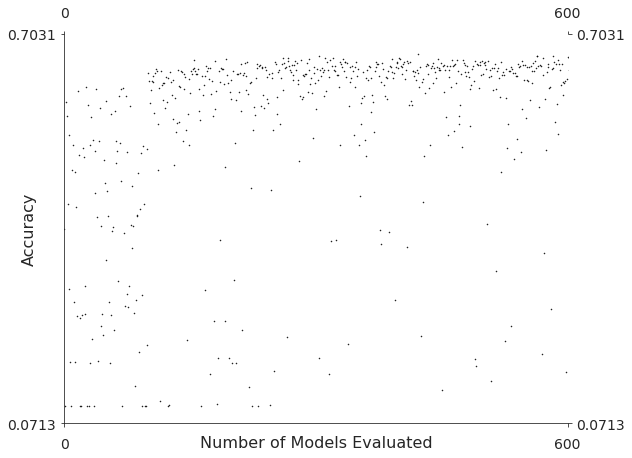

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
# Here we extract the history, the population and the best model
history, population, model_best = history_and_model
sns.set_style('white')
xvalues = range(len(history))
yvalues = [i[1] for i in history]
ax = plt.gca()
ax.scatter(
    xvalues, yvalues, marker='.', facecolor=(0.0, 0.0, 0.0),
    edgecolor=(0.0, 0.0, 0.0), linewidth=1, s=1)
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=2))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
fig = plt.gcf()
fig.set_size_inches(8, 6)
fig.tight_layout()
ax.tick_params(
    axis='x', which='both', bottom='on', top='off', labelbottom='on',
    labeltop='off', labelsize=14, pad=10)
ax.tick_params(
    axis='y', which='both', left='on', right='off', labelleft='on',
    labelright='off', labelsize=14, pad=5)
plt.xlabel('Number of Models Evaluated', labelpad=-16, fontsize=16)
plt.ylabel('Accuracy', labelpad=-30, fontsize=16)
plt.xlim(0, 600)
sns.despine()

In [ ]:
model_best

([(1, None),
  (0, 16),
  (0, 16),
  (-1, <function __main__.random_element.<locals>.<lambda>>),
  (1, None),
  (0, 16),
  (2, ('renorm', True)),
  (0, 16),
  (-1, <function __main__.random_element.<locals>.<lambda>>),
  (1, None)],
 0.6743999719619751)

# Run continuation

In [ ]:
model_best_scaled = []
scaling_factor = 2
scaling_exp = 1
for el in model_best[0]:
  if el[0] == 0:
    new_el = (el[0], el[1]*scaling_factor**scaling_exp)
    scaling_exp += 1
  else:
    new_el = el
  model_best_scaled.append(new_el)
model = AnnModel(gene_dictionary=available_genes, model_list=model_best_scaled)
learning_rate = LEARNING_RATE
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, metrics=['accuracy'], loss='categorical_crossentropy')
history_test = model.fit(x_train, y_train, batch_size=2048, epochs=60,
                         verbose=2, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/60
49/49 - 1s - loss: 1.8549 - accuracy: 0.3708 - val_loss: 4.8713 - val_accuracy: 0.1678
Epoch 2/60
49/49 - 1s - loss: 1.3190 - accuracy: 0.5324 - val_loss: 10.3075 - val_accuracy: 0.1244
Epoch 3/60
49/49 - 1s - loss: 1.0494 - accuracy: 0.6290 - val_loss: 11.7640 - val_accuracy: 0.1860
Epoch 4/60
49/49 - 1s - loss: 0.8641 - accuracy: 0.6969 - val_loss: 11.7456 - val_accuracy: 0.1850
Epoch 5/60
49/49 - 1s - loss: 0.7325 - accuracy: 0.7438 - val_loss: 6.3978 - val_accuracy: 0.2946
Epoch 6/60
49/49 - 1s - loss: 0.6389 - accuracy: 0.7772 - val_loss: 2.1457 - val_accuracy: 0.4932
Epoch 7/60
49/49 - 1s - loss: 0.5460 - accuracy: 0.8092 - val_loss: 1.1410 - val_accuracy: 0.6433
Epoch 8/60
49/49 - 1s - loss: 0.4689 - accuracy: 0.8369 - val_loss: 1.0231 - val_accuracy: 0.6805
Epoch 9/60
49/49 - 1s - loss: 0.4000 - accuracy: 0.8597 - val_loss: 1.0789 - val_accuracy: 0.6843
Epoch 10/60
49/49 - 1s - loss: 0.3449 - accuracy: 0.8779 - val_loss: 1.2043 - val_accuracy: 0.6860
Epoch 11/60
49/4

In [11]:
# Create an training generator:
idg = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=False, rotation_range=35, 
                                                      width_shift_range=0.2, height_shift_range=0.2,
                                                      shear_range=0.1)
model_best_scaled = []
scaling_factor = 2
scaling_exp = 1
for el in model_best[0]:
  if el[0] == 0:
    new_el = (el[0], el[1]*scaling_factor**scaling_exp)
    scaling_exp += 1
  else:
    new_el = el
  model_best_scaled.append(new_el)
model = AnnModel(gene_dictionary=available_genes, model_list=model_best_scaled)
learning_rate = LEARNING_RATE
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, metrics=['accuracy'], loss='categorical_crossentropy')
history_test = model.fit(idg.flow(x_train, y_train, batch_size=2048), epochs=180, steps_per_epoch=len(x_train)/2048,
                         verbose=2, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/180
49/48 - 20s - loss: 2.1596 - accuracy: 0.2577 - val_loss: 2.6698 - val_accuracy: 0.0962
Epoch 2/180
49/48 - 19s - loss: 1.7522 - accuracy: 0.3654 - val_loss: 9.9112 - val_accuracy: 0.1207
Epoch 3/180
49/48 - 20s - loss: 1.5750 - accuracy: 0.4339 - val_loss: 7.3309 - val_accuracy: 0.1158
Epoch 4/180
49/48 - 19s - loss: 1.4719 - accuracy: 0.4738 - val_loss: 2.5517 - val_accuracy: 0.2550
Epoch 5/180
49/48 - 20s - loss: 1.3851 - accuracy: 0.5068 - val_loss: 1.6542 - val_accuracy: 0.4280
Epoch 6/180
49/48 - 20s - loss: 1.3275 - accuracy: 0.5277 - val_loss: 1.3862 - val_accuracy: 0.4954
Epoch 7/180
49/48 - 20s - loss: 1.2688 - accuracy: 0.5502 - val_loss: 1.2898 - val_accuracy: 0.5375
Epoch 8/180
49/48 - 20s - loss: 1.2197 - accuracy: 0.5681 - val_loss: 1.1451 - val_accuracy: 0.5991
Epoch 9/180
49/48 - 20s - loss: 1.1783 - accuracy: 0.5843 - val_loss: 1.1459 - val_accuracy: 0.5944
Epoch 10/180
49/48 - 20s - loss: 1.1517 - accuracy: 0.5941 - val_loss: 1.2017 - val_accuracy: 0.5938